### Лабораторная №3

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import t
from itertools import product
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.linear_model import (LinearRegression, BayesianRidge,
                                  Lasso, Ridge, ElasticNet, Lars)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

Загрузим данные для обучения и для теста и глянем на столбцы


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head(5)

,id,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
0,896,2,0,46.0,3,5,0,0,0,0,...,2,3,0,7,3,13,2,7,18,2350000.0
1,399,2,0,44.6,5,5,0,0,0,0,...,3,5,0,7,3,11,1,4,11,1799000.0
2,1515,2,0,53.0,1,9,0,1,0,0,...,4,11,0,5,3,17,3,7,15,2800000.0
3,1216,2,0,64.0,4,5,0,0,0,1,...,31,5,1,55,2,10,28,32,17,3970000.0
4,677,1,0,33.3,1,10,0,0,1,0,...,1,3,0,2,3,9,0,3,6,1880000.0


Посмотрим типы данных

In [3]:
df_train.dtypes

id                             int64
Количество.комнат              int64
Студия                         int64
Общая.площадь                float64
Этаж                           int64
Этажей.в.доме                  int64
Парковка                       int64
Без.ремонта                    int64
Дизайнерский                   int64
Евроремонт                     int64
Косметический                  int64
Балкон                         int64
Лоджия                         int64
Совмещенный.санузел            int64
Раздельный.санузел             int64
Лифт                           int64
Грузовой.лифт                  int64
Мусоропровод                   int64
Год.постройки                  int64
Аварийный                      int64
Железобетонные.перекрытия      int64
Смешанные.перекрытия           int64
Деревянные.перекрытия          int64
Иные.перекрытия                int64
Панельные.стены                int64
Блочные.стены                  int64
Деревянные.стены               int64
К

И проверим на наличие NaN

In [4]:
df_train.isnull().sum()

id                           0
Количество.комнат            0
Студия                       0
Общая.площадь                0
Этаж                         0
Этажей.в.доме                0
Парковка                     0
Без.ремонта                  0
Дизайнерский                 0
Евроремонт                   0
Косметический                0
Балкон                       0
Лоджия                       0
Совмещенный.санузел          0
Раздельный.санузел           0
Лифт                         0
Грузовой.лифт                0
Мусоропровод                 0
Год.постройки                0
Аварийный                    0
Железобетонные.перекрытия    0
Смешанные.перекрытия         0
Деревянные.перекрытия        0
Иные.перекрытия              0
Панельные.стены              0
Блочные.стены                0
Деревянные.стены             0
Кирпичные.стены              0
Монолитные.стены             0
Смешанные.стены              0
Школа.1000                   0
ВУЗ.1000                     0
ТЦ.1000 

Идентификационный номер нам едва ли пригодится, убираем его из показательных признаков

In [5]:
df_train.drop('id', axis=1, inplace=True)

### Исследуем данные на коллинеарность

Построим матрицу корреляции

<AxesSubplot: >

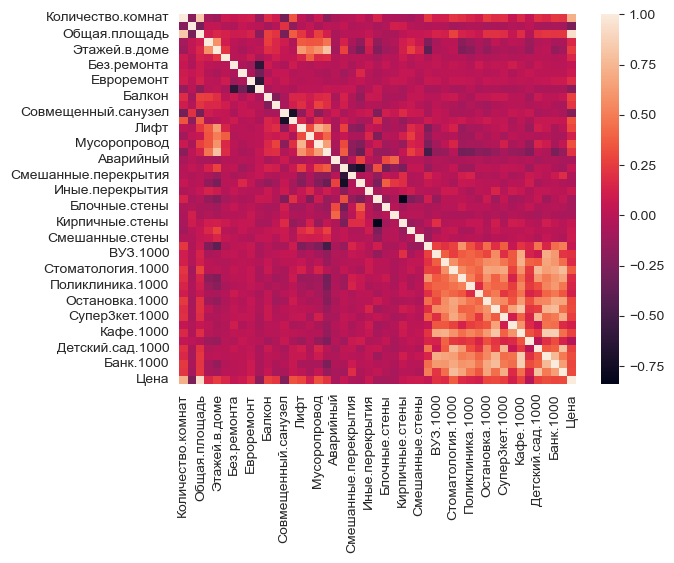

In [6]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix)

Отфильтруем признаки с корреляцией ниже порогового значения и найдем сильно корелирующие друг с другом

In [7]:
# Слабо коррелирующие с целевым признаком
target = 'Цена'
cors = {}
for f in df_train.columns:
     cors[f] = df_train[target].corr(df_train[f])
threshold = 0.29
weakly_correlated = [f for f, corr in cors.items() if abs(corr) < threshold]

Удалим элементы и построим матрицу снова

<AxesSubplot: >

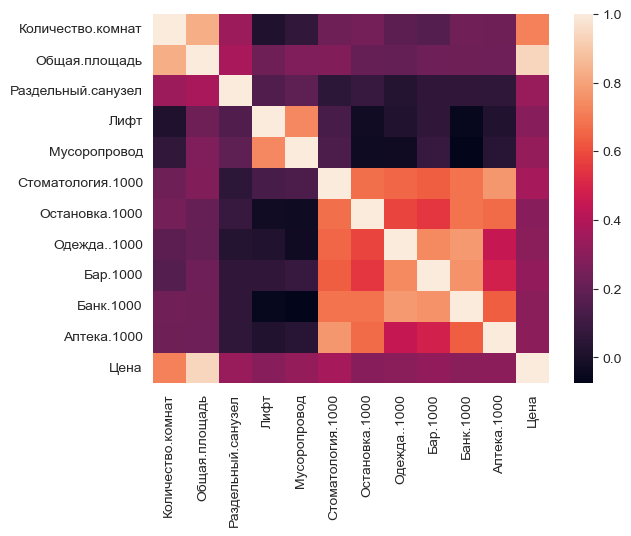

In [8]:
df_train.drop(weakly_correlated, axis=1, inplace=True)
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix)

In [9]:
# Сильно коррелирующие друг с другом

features = df_train.drop('Цена', axis=1)
corr_matrix = features.corr()

high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.75:
            high_corr_features.add((corr_matrix.columns[i], corr_matrix.columns[j]))

price_corr = df_train.corr()['Цена']
to_drop = set()
for feat1, feat2 in high_corr_features:
    if abs(price_corr[feat1]) < abs(price_corr[feat2]):
        to_drop.add(feat1)
    else:
        to_drop.add(feat2)

df_train.drop(to_drop, axis=1, inplace=True)

Еще раз взглянем на матрицу

<AxesSubplot: >

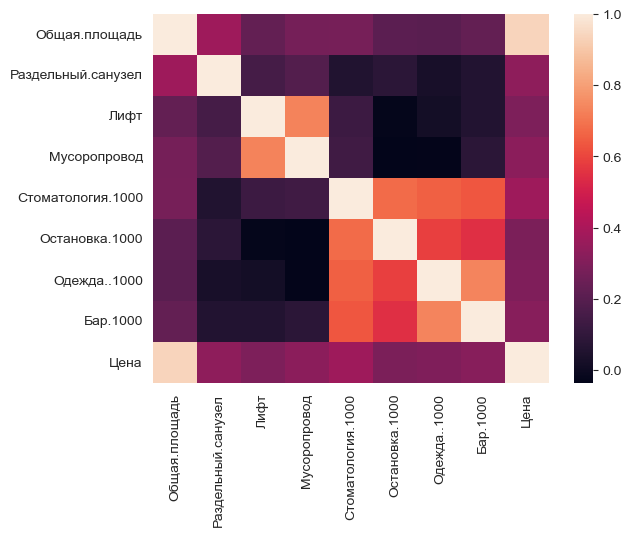

In [10]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix)

### Построим модели

In [11]:
x = df_train.loc[:, df_train.columns != 'Цена']
y = df_train['Цена']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                    random_state=21)
results = []

In [12]:
def get_model_stats(model, X_test, y_test):
    if hasattr(model, "predict"):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.fit(X_test)[0]
    n, p = X_test.shape
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    aic = n * np.log(mean_squared_error(y_test, y_pred)) + 2 * p
    bic = n * np.log(mean_squared_error(y_test, y_pred)) + p * np.log(n)
    res = pd.Series({
        "R^2": r2,
        "Adj r^2": adj_r2,
        "RMSE": rmse,
        "AIC": aic,
        "BIC": bic
    })
    display(res)
    return res

def get_model_coef_stats(model, coef, X, y, i):
    # поиск стандартной ошибки
    y_pred = model.predict(X)

    mse = ((y_pred - y)**2).mean()
    s_err = np.sqrt(mse * np.linalg.inv(X.T @ X).diagonal())[i]


    # поиск статистики стьюдента
    t_value = coef / s_err

    # проверка значимости коэффициента
    df = X.shape[0] - X.shape[1]
    p_value = 2 * (1 - t.cdf(np.abs(t_value), df))
    is_valuable = (np.abs(t_value) > 1.96) & (p_value < 0.05)

    # нахождение 95%-доверительного интервала
    se = s_err * t.ppf(0.95, df)
    lower_ci = coef - se
    upper_ci = coef + se


    return t_value, p_value, is_valuable, lower_ci, upper_ci

def coef_stats(model, X, y, lib):
    coef_data = {
            'Name': [],
            't-value': [],
            'p-value': [],
            'Is valuable': [],
            '95% Confidence Interval': [],
        }
    if lib == 'scl':
        coeffs = model.coef_
    else:
        coeffs = model.params.values
    for i, col_name in enumerate(X.columns):
        res = get_model_coef_stats(model, coeffs[i], X, y, i)
        coef_data['Name'].append(col_name)
        coef_data['t-value'].append(res[0])
        coef_data['p-value'].append(res[1])
        coef_data['Is valuable'].append(res[2])
        coef_data['95% Confidence Interval'].append(f'[{res[3]}, {res[4]}]')
    return pd.DataFrame(coef_data)

def sm_grid(orig_model, params, X, y):
     kf = KFold(n_splits=5, shuffle=True)
     param_keys = params.keys()
     combinations = product(*params.values())
     bests = []
     for comb in combinations:
         pars = dict(zip(param_keys, comb))
         rmses = []
         for train_idx, test_idx in kf.split(X):
             x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
             model = orig_model(y_train, x_train, **pars).fit()
             y_pred = model.predict(x_test)
             rmses.append((model, mean_squared_error(y_test, y_pred, squared=False)))
         bests.append(min(rmses, key=lambda ms: ms[1]))
     return min(bests, key=lambda ms: ms[1])[0]




In [13]:
stats_summary = {}

Линейная регрессия (МНК)


In [14]:
lr = LinearRegression()

# Определение последовательности выбора признаков
selector = SequentialFeatureSelector(lr).fit(x_train, y_train)
features = selector.get_support()
lr_x_train = x_train.loc[:, features]
lr_x_test = x_test.loc[:, features]

params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [1, 2, 4, 8],
}
grid = GridSearchCV(lr, params, cv=5, scoring='neg_mean_squared_error').fit(lr_x_train, y_train)
model = grid.best_estimator_



stats_summary["LinearRegression"] = get_model_stats(model, lr_x_test, y_test)
display(coef_stats(model, lr_x_test, y_test, 'scl'))

R^2             0.905761
Adj r^2         0.904177
RMSE       336023.184286
AIC          6192.318623
BIC          6206.290868
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,56.053707,0.000000,True,"[46704.805107358574, 49540.02665806436]"
1,Мусоропровод,4.368862,0.000019,True,"[122244.01583015715, 270798.14125137834]"
2,Остановка.1000,2.115818,0.035395,True,"[2123.91310391596, 17222.457841069954]"
3,Одежда..1000,3.644090,0.000329,True,"[3714.606430543261, 9870.417401702527]"


Лассо регрессия

In [15]:
lasr = Lasso()

params = {
    'alpha': np.logspace(-4, 2, 7),
    'fit_intercept': [True, False],
    'precompute': [True, False, 'auto'],
    'max_iter': [1000, 5000, 10000],
    'tol': [0.001, 0.0001, 0.00001]
}
grid = GridSearchCV(lasr, params, cv=5, scoring='neg_mean_squared_error').fit(x_train, y_train)
model = grid.best_estimator_

stats_summary["Lasso"] = get_model_stats(model, x_test, y_test)
display(coef_stats(model, x_test, y_test, 'scl'))

R^2             0.910582
Adj r^2         0.907524
RMSE       327315.970880
AIC          6187.559090
BIC          6215.503582
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,51.883040,0.000000,True,"[46678.09435619568, 49747.173792829984]"
1,Раздельный.санузел,-0.688154,0.492035,False,"[-108749.89517091846, 44773.75115284373]"
2,Лифт,1.405778,0.161111,False,"[-14433.32953645596, 179671.33842045208]"
3,Мусоропровод,1.766461,0.078617,False,"[7850.755526521141, 233128.28503580624]"
4,Стоматология.1000,0.666078,0.506015,False,"[-5670.854582597511, 13338.131565996928]"
5,Остановка.1000,1.434830,0.152665,False,"[-1100.8256801084663, 15689.78260228448]"
6,Одежда..1000,1.912391,0.057042,False,"[669.5528576783172, 9141.258666014379]"
7,Бар.1000,0.544864,0.586364,False,"[-7685.810280067918, 15255.119267471211]"


Гребневая регрессия

In [16]:
ridr = Ridge()

params = {
    'alpha': np.logspace(-4, 2, 7),
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000, 5000, 10000],
    'tol': [0.001, 0.0001, 0.00001]
}
grid = GridSearchCV(ridr, params, cv=5, scoring='neg_mean_squared_error').fit(x_train, y_train)
model = grid.best_estimator_

stats_summary["Ridge"] = get_model_stats(model, x_test, y_test)
display(coef_stats(model, x_test, y_test, 'scl'))

R^2             0.910824
Adj r^2         0.907775
RMSE       326872.218253
AIC          6186.899757
BIC          6214.844249
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,51.832607,0.000000,True,"[46568.00917055398, 49632.92775900672]"
1,Раздельный.санузел,-0.167576,0.867061,False,"[-84436.77102321398, 68878.73843155534]"
2,Лифт,1.709244,0.088726,False,"[3397.1008413657983, 197238.6149531635]"
3,Мусоропровод,1.318246,0.188705,False,"[-22691.006191639695, 202281.10743696973]"
4,Стоматология.1000,0.734285,0.463507,False,"[-5271.128206483533, 13712.086857626935]"
5,Остановка.1000,1.391383,0.165425,False,"[-1319.9109368484842, 15447.933786183623]"
6,Одежда..1000,1.856014,0.064703,False,"[524.22886766175, 8984.449316157823]"
7,Бар.1000,0.581237,0.561638,False,"[-7423.0819655425075, 15486.745837332863]"


Elastic-Net

In [17]:
eln = ElasticNet()

params = {
    'alpha': np.logspace(-4, 0, 50),
    'l1_ratio': [0.25, 0.5, 0.75]
}
grid = GridSearchCV(eln, params, cv=5, scoring='neg_mean_squared_error').fit(x_train, y_train)
model = grid.best_estimator_

stats_summary["ElasticNet"] = get_model_stats(model, x_test, y_test)
display(coef_stats(model, x_test, y_test, 'scl'))

R^2             0.911445
Adj r^2         0.908417
RMSE       325732.082794
AIC          6185.201618
BIC          6213.146110
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,52.986093,0.000000,True,"[47472.276834363445, 50526.5049383784]"
1,Раздельный.санузел,-0.459511,0.646292,False,"[-97646.85555256292, 55133.886984065706]"
2,Лифт,1.419628,0.157041,False,"[-13553.407716552989, 179611.9841328726]"
3,Мусоропровод,1.385946,0.167077,False,"[-18016.432429278677, 206170.97491422875]"
4,Стоматология.1000,0.768980,0.442678,False,"[-5054.0225795533415, 13862.978730630086]"
5,Остановка.1000,1.757616,0.080115,False,"[537.5589120523528, 17246.917127892288]"
6,Одежда..1000,1.765360,0.078802,False,"[290.9943454630529, 8721.705411430754]"
7,Бар.1000,0.521880,0.602246,False,"[-7807.493268329361, 15022.424693376992]"


Метод наименьших углов (Least-angle regression)

In [18]:
lar = Lars()

selector = SequentialFeatureSelector(lar).fit(x_train, y_train)
features = selector.get_support()
lar_x_train = x_train.loc[:, features]
lar_x_test = x_test.loc[:, features]

params = {
    'fit_intercept': [True, False],
    'precompute': [True, False, 'auto'],
    'n_nonzero_coefs': [5, 10, 20],
    'eps': [1e-4, 1e-5, 1e-6]
}
grid = GridSearchCV(lar, params, cv=5, scoring='neg_mean_squared_error').fit(lar_x_train, y_train)
model = grid.best_estimator_

stats_summary["Lars"] = get_model_stats(model, lar_x_test, y_test)
display(coef_stats(model, lar_x_test, y_test, 'scl'))

R^2             0.905761
Adj r^2         0.904177
RMSE       336023.184286
AIC          6192.318623
BIC          6206.290868
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,56.053707,0.000000,True,"[46704.80510735855, 49540.02665806434]"
1,Мусоропровод,4.368862,0.000019,True,"[122244.01583015786, 270798.14125137904]"
2,Остановка.1000,2.115818,0.035395,True,"[2123.9131039160748, 17222.45784107007]"
3,Одежда..1000,3.644090,0.000329,True,"[3714.6064305432346, 9870.4174017025]"


Байесовская регрессия

In [19]:
br = BayesianRidge()

params ={
    'n_iter': [100, 300, 500],
    'tol': [1e-3, 1e-4, 1e-5],
}
grid = GridSearchCV(br, params, cv=5, scoring='neg_mean_squared_error').fit(x_train, y_train)
model = grid.best_estimator_

stats_summary["BayesianRidge"] = get_model_stats(model, x_test, y_test)
display(coef_stats(model, x_test, y_test, 'scl'))

R^2             0.911427
Adj r^2         0.908399
RMSE       325764.511987
AIC          6185.250001
BIC          6213.194493
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,52.989650,0.000000,True,"[47480.29236791186, 50534.82454437408]"
1,Раздельный.санузел,-0.447889,0.654646,False,"[-97118.92312307307, 55677.029938996944]"
2,Лифт,1.409218,0.160093,False,"[-14163.700174802754, 179020.92280976684]"
3,Мусоропровод,1.363545,0.174016,False,"[-19538.9510087916, 204670.77595567345]"
4,Стоматология.1000,0.776662,0.438139,False,"[-5010.516784222125, 13908.36786233555]"
5,Остановка.1000,1.745979,0.082121,False,"[478.7298766701315, 17189.751640638136]"
6,Одежда..1000,1.761036,0.079533,False,"[279.9826565850399, 8711.533066196636]"
7,Бар.1000,0.524962,0.600104,False,"[-7786.963173981573, 15045.227685749858]"


Обобщенная линейная регрессия (обобщенный МНК)

In [20]:
gls = sm.GLS
params = {'sigma': [0.1, 0.5, 1.0],
    'hasconst': [True, False]}
model = sm_grid(gls, params, x_train, y_train)
stats_summary["GLS"] = get_model_stats(model, x_test, y_test)
display(coef_stats(model, x_test, y_test, 'sm'))

R^2             0.910596
Adj r^2         0.907539
RMSE       327289.969472
AIC          6187.520481
BIC          6215.464973
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,52.034445,0.000000,True,"[46815.06917773369, 49883.90481206903]"
1,Раздельный.санузел,-0.593120,0.553671,False,"[-104324.07241713376, 49187.378256860815]"
2,Лифт,1.596378,0.111748,False,"[-3231.3049914262956, 190857.94363038026]"
3,Мусоропровод,1.621438,0.106265,False,"[-2041.0204342137877, 223218.61342240672]"
4,Стоматология.1000,0.142727,0.886628,False,"[-8682.334145223562, 10325.141962780668]"
5,Остановка.1000,1.506657,0.133242,False,"[-735.6109842780606, 16053.66348157977]"
6,Одежда..1000,1.853337,0.065087,False,"[518.0342289060209, 8989.067059759807]"
7,Бар.1000,0.946641,0.344794,False,"[-4894.651973288308, 18044.455186958672]"


Взвешенный МНК

In [21]:
wls = sm.WLS
params = {'hasconst': [True, False]}
model = sm_grid(wls, params, x_train, y_train)
stats_summary["WLS"] = get_model_stats(model, x_test, y_test)
display(coef_stats(model, x_test, y_test, 'sm'))

R^2             0.911284
Adj r^2         0.908251
RMSE       326027.107465
AIC          6185.641603
BIC          6213.586095
dtype: float64

,Name,t-value,p-value,Is valuable,95% Confidence Interval
0,Общая.площадь,52.558714,0.000000,True,"[47119.692973933576, 50176.68737788826]"
1,Раздельный.санузел,-1.132622,0.258527,False,"[-128900.94880776234, 24018.171526620295]"
2,Лифт,1.889875,0.060005,False,"[13962.391354760563, 207302.73850995713]"
3,Мусоропровод,0.868012,0.386273,False,"[-53221.662363860916, 171168.7977937467]"
4,Стоматология.1000,1.096595,0.273941,False,"[-3180.419510784932, 15753.715457331762]"
5,Остановка.1000,1.105691,0.269991,False,"[-2763.2011932629584, 13961.291156325784]"
6,Одежда..1000,1.943200,0.053186,False,"[745.6310634799383, 9183.978060596026]"
7,Бар.1000,0.415350,0.678265,False,"[-8551.616779627555, 14298.9788782203]"


Полиномиальная регрессия

In [22]:
pr = LinearRegression()

selector = PolynomialFeatures(degree=2)
pr_x_train = selector.fit_transform(x_train)
pr_x_test = selector.fit_transform(x_test)

params ={
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False],
}
grid = GridSearchCV(pr, params, cv=5, scoring='neg_mean_squared_error').fit(pr_x_train, y_train)
model = grid.best_estimator_

stats_summary["Polinom"] = get_model_stats(model, pr_x_test, y_test)

R^2             0.911400
Adj r^2         0.891162
RMSE       325814.175817
AIC          6259.324088
BIC          6416.511853
dtype: float64

Непараметрическая регрессия

In [28]:
n_p = sm.nonparametric.KernelReg(y_train, x_train, var_type="".join(
    ["c" if len(x_train[col].value_counts()) > 2 else "u" for col in
     x_train.columns]))
stats_summary["Nonparametric"] = get_model_stats(n_p, x_test, y_test)

R^2             0.886429
Adj r^2         0.885958
RMSE       368882.102008
AIC          6231.660929
BIC          6235.153991
dtype: float64

In [24]:
stats_summary

{'LinearRegression': R^2             0.905761
 Adj r^2         0.904177
 RMSE       336023.184286
 AIC          6192.318623
 BIC          6206.290868
 dtype: float64,
 'Lasso': R^2             0.910582
 Adj r^2         0.907524
 RMSE       327315.970880
 AIC          6187.559090
 BIC          6215.503582
 dtype: float64,
 'Ridge': R^2             0.910824
 Adj r^2         0.907775
 RMSE       326872.218253
 AIC          6186.899757
 BIC          6214.844249
 dtype: float64,
 'ElasticNet': R^2             0.911445
 Adj r^2         0.908417
 RMSE       325732.082794
 AIC          6185.201618
 BIC          6213.146110
 dtype: float64,
 'Lars': R^2             0.905761
 Adj r^2         0.904177
 RMSE       336023.184286
 AIC          6192.318623
 BIC          6206.290868
 dtype: float64,
 'BayesianRidge': R^2             0.911427
 Adj r^2         0.908399
 RMSE       325764.511987
 AIC          6185.250001
 BIC          6213.194493
 dtype: float64,
 'GLS': R^2             0.910596
 Adj r^2

### Оценка моделей

[336023.18428555183, 327315.970880108, 326872.21825318906, 325732.0827939474, 336023.18428555183, 325764.5119865941, 327289.9694722481, 326027.10746476974, 325814.17581650487, 420057.30148573825]


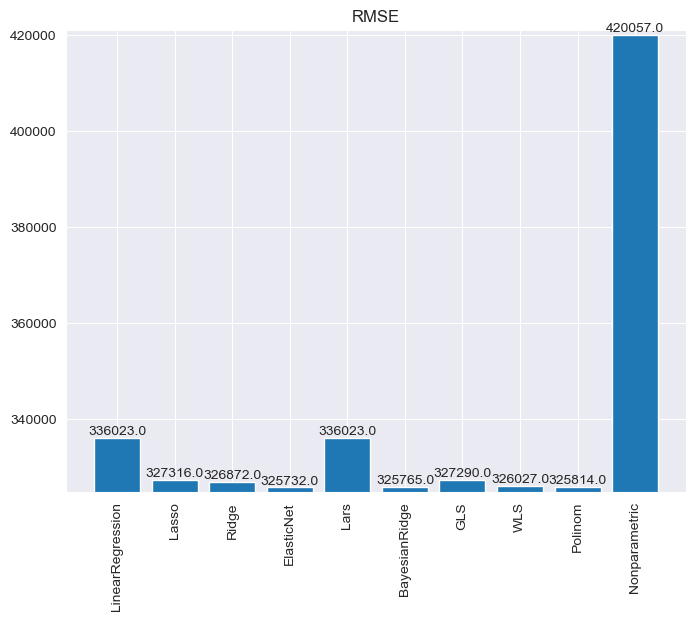

In [25]:
rmse = []
for name in stats_summary.keys():
    rmse.append(stats_summary[name]["RMSE"])
plt.figure(figsize=(8, 6))
plt.title("RMSE")
plt.ylim([min(rmse) - 1000, max(rmse) + 1000])
plt.bar(stats_summary.keys(), rmse)
plt.xticks(rotation=90)
print(rmse)
for i, score in enumerate(rmse):
    plt.text(i, score, str(round(score, 0)), ha='center', va='bottom')
plt.show()